In [3]:
import qiskit
from qiskit import quantum_info
from qiskit.execute_function import execute
from qiskit import BasicAer
import numpy as np
import pickle
import json
import os
from collections import Counter
from sklearn.metrics import mean_squared_error
from typing import Dict, List
import matplotlib.pyplot as plt

#define utility functions

def simulate(circuit: qiskit.QuantumCircuit) -> dict:
    """Simulate the circuit, give the state vector as the result."""
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    state_vector = result.get_statevector()
    
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    
    return histogram


def histogram_to_category(histogram):
    """This function take a histogram representations of circuit execution results, and process into labels as described in 
    the problem description."""
    assert abs(sum(histogram.values())-1)<1e-8
    positive=0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
        
    return positive


def count_gates(circuit: qiskit.QuantumCircuit) -> Dict[int, int]:
    """Returns the number of gate operations with each number of qubits."""
    counter = Counter([len(gate[1]) for gate in circuit.data])
    #feel free to comment out the following two lines. But make sure you don't have k-qubit gates in your circuit
    #for k>2
    for i in range(2,20):
        assert counter[i]==0
        
    return counter


def image_mse(image1,image2):
    # Using sklearns mean squared error:
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
    return mean_squared_error(image1, image2)

In [4]:
#load the mock data (for testing only)
files=os.listdir("mock_data")
dataset=list()
for file in files:
    with open('mock_data/'+file, "r") as infile:
        loaded = json.load(infile)
        dataset.append(loaded)

IsADirectoryError: [Errno 21] Is a directory: 'mock_data/.ipynb_checkpoints'

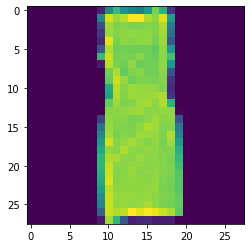

In [5]:
#load the actual hackthon data (fashion-mnist)
images=np.load('data/images.npy')
labels=np.load('data/labels.npy')
#you can visualize it
plt.imshow(images[1100])

In [25]:
#submission to part 1, you should make this into a .py file

n=len(dataset)
mse=0
gatecount=0

# Functions 'encode' and 'decode' are dummy.
def encode(image):
    
    image = np.array(image)
    
    num_qubits = 10
    
    flat_img = image.flatten()
    
    num_zeros = 2**num_qubits - len(flat_img)
    
    # pad the flattened img on the right to make it into a statevector
    flat_img = np.pad(flat_img,(0,num_zeros),"constant")
    # then normalize - need to think about how to do this step better
    
    print(np.sum(flat_img**2))
    
    flat_img = flat_img/np.sqrt(np.sum(flat_img**2))
                                 
    print(np.sum(flat_img**2))
    
    q = qiskit.QuantumRegister(num_qubits)
    circuit = qiskit.QuantumCircuit(q)
    
    circuit.initialize(flat_img, circuit.qubits)
    circuit.draw()
    
    return circuit

def decode(histogram):
    
    num_pixels = 28**2
    num_qubits = 10
    
    flat_img = np.zeros(2**num_qubits)
    
    for i in histogram:
        flat_img[i] = histogram[i]
        
    flat_img = flat_img[:num_pixels]
    
    image = flat_img.reshape((28,28))
    
    return image

def run_part1(image):
    #encode image into a circuit
    circuit=encode(image)
    
    #simulate circuit
    histogram=simulate(circuit)
    
    #reconstruct the image
    image_re=decode(histogram)

    return circuit,image_re

In [26]:
#how we grade your submission

n=len(dataset)
mse=0
gatecount=0

for data in dataset:
    #encode image into circuit
    circuit,image_re=run_part1(data['image'])
    
    #count the number of 2qubit gates used
    gatecount+=count_gates(circuit)[2]
    
    #calculate mse
    mse+=image_mse(data['image'],image_re)
    
#fidelity of reconstruction
f=1-mse
gatecount=gatecount/n

#score for part1 
print(f*(0.999**gatecount))

4
1.0


AssertionError: 